# zbMATH Full Experiment & Analysis
### Orion Portelli

This notebook explains and defines the process used to collect and analyse zbMATH record data in a reproduciple manner.
___
## Data Collection Process

Data collection takes place in two phases:

1. **ID Collection:** The client first collects a list of record ID's using the zbMATH client.
2. **Record Scraping:** The client scrapes key details (including software) from each record in the ID list.
3. **Data Cleaning:** The client cleans the dataset to fix erroneous dates and clean the plaintext language field.

The first two stages are automated through the use of the `py_client.fullCollect` function.

Cleaning can be then applied using the `py_client.cleanDataset` function.

___

## Phase 1 - Parameter Selection

Collecting records is limited primarily by the speed of HTTP requests to zbMATH. As a result it is important to limit the number of records scraped as much as possible. This can be done during the ID collection phase via two means:

1. **Mathematical Subject:** The MSC of the records being scraped. Different mathematical subjects rely on computational ability more than others, and by limiting ID search to individual subjects it is possible to capture these trends and their differences.
2. **Time Interval:** The start and end date for the ID collection range. Records on zbMATH date back to even the 18th century, however the use of most modern software packages in mathematics was not truly mainstream until the late 2000s. Capturing time varying trends while increasing specificity is an important consideration.

Here I selected 5 mathematical subjects of interest and then used swMATH to find the top subjects in certain large software packages to determine a smaller set of subjects that were sufficiently large and distinct. 
| MSC | Subject |
| --- | --- |
| 05 | Combinatorics |
| 11 | Number Theory |
| 20 | Group Theory & Generalisations |
| 62 | Statistics |
| 65 | Numerical Analysis |

In [3]:
import src.api.api_client as api_client
import src.api.py_client as py_client

In [4]:
# View possible MSC codes
api_client.getClasses()

{'00': 'General and overarching topics; collections',
 '01': 'History and biography',
 '03': 'Mathematical logic and foundations',
 '05': 'Combinatorics',
 '06': 'Order, lattices, ordered algebraic structures',
 '08': 'General algebraic systems',
 '11': 'Number theory',
 '12': 'Field theory and polynomials',
 '13': 'Commutative algebra',
 '14': 'Algebraic geometry',
 '15': 'Linear and multilinear algebra; matrix theory',
 '16': 'Associative rings and algebras',
 '17': 'Nonassociative rings and algebras',
 '18': 'Category theory; homological algebra',
 '19': '\\(K\\)-theory',
 '20': 'Group theory and generalizations',
 '22': 'Topological groups, Lie groups',
 '26': 'Real functions',
 '28': 'Measure and integration',
 '30': 'Functions of a complex variable',
 '31': 'Potential theory',
 '32': 'Several complex variables and analytic spaces',
 '33': 'Special functions',
 '34': 'Ordinary differential equations',
 '35': 'Partial differential equations',
 '37': 'Dynamical systems and ergodic t

In [2]:
sets = {'05': 0, '11': 0, '20': 0, '62': 0, '65': 0}
start = '2010'
end = '2015'

for s in sets:
    sets[s] = api_client.getIDCount(s, start=start, end=end)

print(sets)
print('Total Count:', sum(sets.values()))

{'05': 35450, '11': 21023, '20': 15243, '62': 36205, '65': 49759}
Total Count: 157680


From there, I determined a reasonably wide interval and used the API's count feature to determine if the number of records scraped was reasonable. The selected subjects follow:

| MSC | Subject |
| --- | --- |
| 11 | Number Theory |
| 20 | Group Theory & Generalisations |
| 62 | Statistics |

Again, these were chosen due to the distinction in the area of mathematics they covered, as well as the reasonably small count for sets 11 and 20.

___
## Phase 2 - Data Collection

The code itself won't be run here due to its long runtime, it is better to use scripts or run in it directly from the command line. Despite this, it is shown below for the sake of reproducibility. The list of sets is left blank to avoid being accidentally run and overwriting the existing datasets.

In [ ]:
sets = []

# Collect records
for s in sets:
    py_client.fullCollect(idpath=f'../data/{s}_ids.json', recordpath=f'../data/{s}_records.json', set=s, start=start, end=end)
    
# Clean datasets
for s in sets:
    py_client.cleanDataset(inpath=f'../data/{s}_records.json', outpath=f'../data/{s}_clean.json', strict=False)

___
## Phase 3 - Analysis

For this phase a simple analysis of the data is conducted. See the report for further explanation of the design of this visualisation.

Note: rather than using pandas, the data was manually formatted for the exact visualisation required, however this is not necessary for other projects as pandas supplies support for reading from JSON files

In [49]:
# Import Packages
import numpy as np
import matplotlib.pyplot as plt
import json

# Select figure size
plt.rcParams['figure.figsize'] = [12, 8]

In [41]:
# Get software count for each software in each set
sets = ['11', '20', '62']

soft_counts = {s: {} for s in sets}
total_counts = {}

for s in sets:
    # Import data
    with open(f'../data/{s}_clean.json') as j:
        records = json.load(j)
    total_counts[s] = records['count']
    records = records['records']
    
    # For each record with software, increment value in dictionary
    for r in records:
        if r['software']:
            for soft in r['software'].values():
                if not soft in soft_counts[s]:
                    soft_counts[s][soft] = 1
                else:
                    soft_counts[s][soft] += 1

In [42]:
# Retrieve summary counts for each set
# (top 3 softwares, other, and none)
top = 3
summary_stats = {s: {} for s in sets}

for s in summary_stats:
    # Find top three software for the subject
    keys = sorted(soft_counts[s], key=soft_counts[s].get, reverse=True)[:top]

    # Find the count for each top software and store it
    for k in keys:
        summary_stats[s][k] = soft_counts[s][k]

    # Find number of software not in the top 3
    summary_stats[s]['other'] = sum(soft_counts[s].values()) - sum(summary_stats[s].values())

    # Finally, number of records with no software
    summary_stats[s]['none'] = total_counts[s] - sum(soft_counts[s].values())

print(summary_stats)

{'11': {'OEIS': 483, 'Magma': 291, 'SageMath': 165, 'other': 1324, 'none': 18759}, '20': {'GAP': 483, 'Magma': 233, 'CHEVIE': 53, 'other': 763, 'none': 13711}, '62': {'R': 1374, 'fda (R)': 280, 'SAS': 250, 'other': 12282, 'none': 22019}}


In [43]:
# Format sets for visualisation
subjects = ['Number theory', 'Group Theory', 'Statistics']
nones = [summary_stats[s]['none'] for s in sets]
others = [summary_stats[s]['other'] for s in sets]
majority = [(sum(summary_stats[s].values()) - nones[i] - others[i]) for i,s in enumerate(sets)]

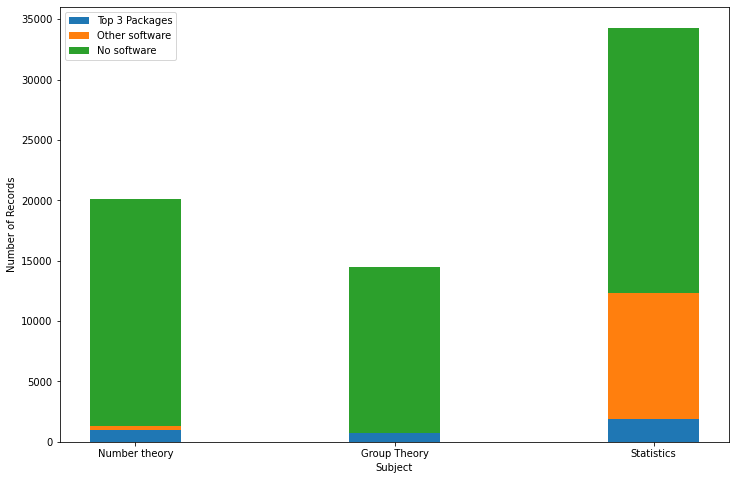

In [50]:
# Stacked bar chart of top software usage
fig, ax = plt.subplots()
width = 0.35 # Width of each bar

ax.bar(subjects, majority, width, label='Top 3 Packages')
ax.bar(subjects, others, width, bottom=majority, label='Other software')
ax.bar(subjects, nones, width, bottom=others, label='No software')


ax.set_ylabel('Number of Records')
ax.set_xlabel('Subject')
ax.legend()

plt.show()

In [53]:
# Get top packages in each subject (ordered by package rank in subject)
top_packages = [[] for i in range(top)]
for s in sets:
    ordered = sorted(soft_counts[s], key=soft_counts[s].get, reverse=True)[:top]
    for i in range(top):
        top_packages[i].append(summary_stats[s][ordered[i]])

print(top_packages)

[[483, 483, 1374], [291, 233, 280], [165, 53, 250]]


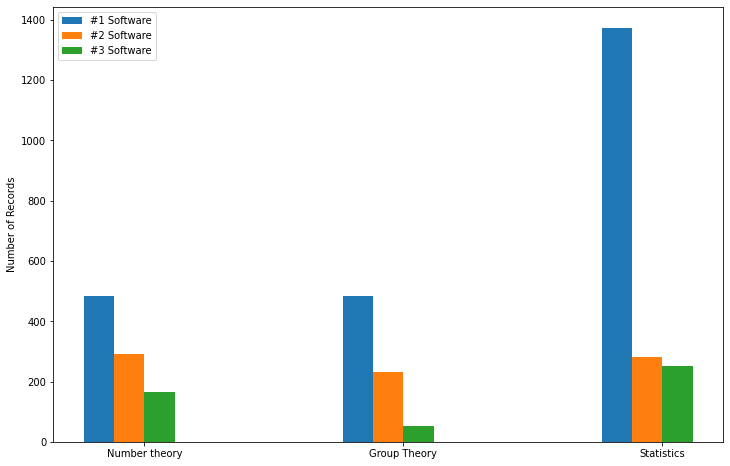

In [59]:
# Visualise grouped bar of top packages by subject
x = np.arange(len(subjects))

fig, ax = plt.subplots()
top1 = ax.bar(x - width/2, top_packages[0], width/3, label='#1 Software')
top2 = ax.bar(x - width/6, top_packages[1], width/3, label='#2 Software')
top2 = ax.bar(x + width/6, top_packages[2], width/3, label='#3 Software')

ax.set_ylabel('Number of Records')
ax.set_xticks(x, subjects)
ax.legend()

plt.show()


The above visualisation shows that R is almost three times as popular as most other top software packages in other subjects.

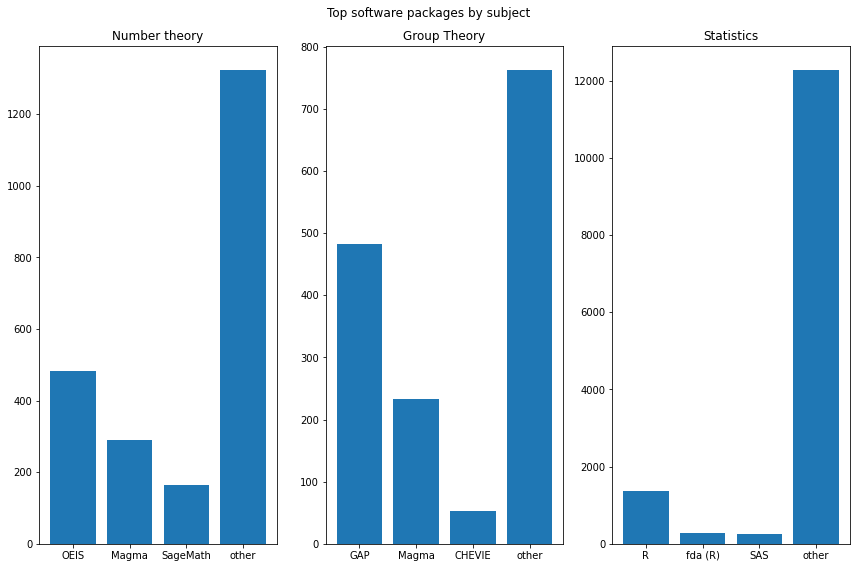

In [58]:
fig, axs = plt.subplots(1, len(sets))
fig.suptitle('Top software packages by subject')

for i,s in enumerate(sets):
    summary_stats[s].pop('none', None)
    labels = summary_stats[s].keys()
    
    axs[i].bar(labels, summary_stats[s].values())
    axs[i].set_title(f'{subjects[i]}')

plt.tight_layout()
plt.show()